With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.


# Practice Skills
* Creative feature engineering
* Advanced regression techniques like random forest and gradient boosting

In [43]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# Now , we load the required files

In [44]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [45]:
train.shape, test.shape

((1460, 81), (1459, 80))

A quick look at the train and test sets , trying to get some intution from the data :

In [46]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [47]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Step 2: Data processing

* (These are CRUCIAL , non optional steps . Real world data is even more noisy)
* Not all data is 'Clean' enough to be used directly for mathematical models. We need to 'Clean' it first !
* Remove Outliers
* Fill up NULL and missing data . Most models can't handle them.

In [48]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

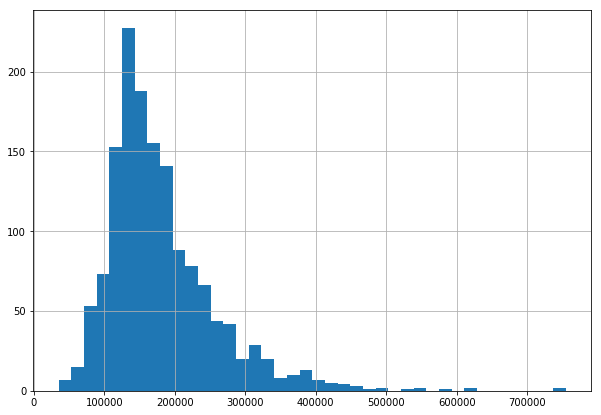

In [49]:
plt.figure(figsize=(10,7))
train['SalePrice'].hist(bins=40)
plt.show()

SalePrice is not uniformly distributed and is skewed towards the left . Therefore , we use log1p to remove the skewness .

We take log as logs are used to respond to skewness towards large values; i.e., cases in which one or a few points are much larger than the bulk of the data.

In [50]:
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice'].reset_index(drop=True)

As you can see below , the data is now more balanced , suitable for training and prediction purposes

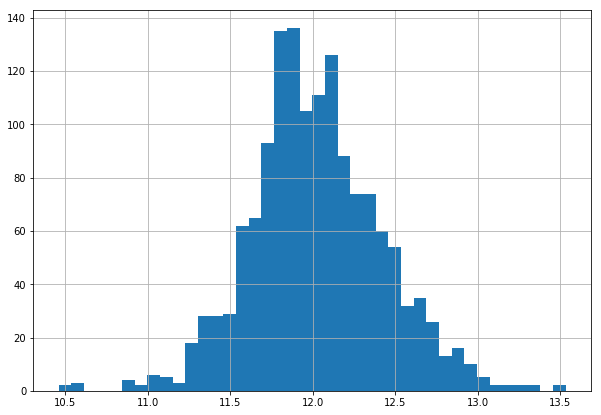

In [51]:
plt.figure(figsize=(10,7))
train['SalePrice'].hist(bins=40)
plt.show()

In [52]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

Now , we are merging train and test datasets , so that we can handle 'noise' and missing data in the dataset .

In [53]:
features.shape

(2917, 79)

In [54]:
# Since these column are actually a category , using a numerical number will lead the model to assume
# that it is numerical , so we convert to string .
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

## Filling these columns With most suitable value for these columns 
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna('SBrkr')
features['KitchenQual'] = features['KitchenQual'].fillna('TA')
features['PoolQC'] = features['PoolQC'].fillna('None')

## Filling these with MODE , i.e. , the most frequent value in these columns.
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [55]:
# Missing data in GarageYrBlt most probably means missing Garage, so replace NaN with zero.

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
    
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

# Same with basement

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

This code will filll the missing values with the mode (The frequently category appearing) By each MSsubclass:

In [56]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

Fill the remaining columns as None

In [57]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))
print(objects)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


For missing values in numerical cols , we fillNa with 0.

In [58]:
# we are still filling up missing values
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))
numerics[1:10]

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF']

In [59]:
numeric_dtypes = ['int16','int32','int64','float16','float32','float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

# Step 3, Feature Engineering

Removing features that are not very useful. This can be understood only by doing proper EDA on data

In [60]:
features.drop(['Utilities', 'Street', 'PoolQC'], axis=1, inplace=True)

# Adding new features . Make sure that you understand this. 

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [61]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

Now we have 86 columns , having added around 7 more to our data

In [62]:
features.shape

(2917, 86)

Get_dummies converts Categorical data to numerical, as models don't work with Text data

In [63]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 333)

Understandably so , no. of columns is increased .

# Here , Again train and test are spilt back seperately , as now all data processing is done .
Y is taget and its length is used to split

In [64]:
x = final_features.iloc[:len(y),:]
x_test = final_features.iloc[len(y):,:]
x.shape, y.shape, x_test.shape

((1458, 333), (1458,), (1459, 333))

# Removing outliers . Read other Kernels to understand how they were found out.
A few were already stated by the dataset provider , others can be seen by plotting them in a graph

In [65]:
outliers = [30, 88, 462, 631, 1322]
x = x.drop(x.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in x.columns:
    counts = x[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(x) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
x = x.drop(overfit, axis=1)
x_sub = x_test.drop(overfit, axis=1)
overfit

['MSSubClass_150']

Turns out we have dropped just one column (Compare the shape)

In [66]:
x.shape, y.shape, x_test.shape

((1453, 332), (1453,), (1459, 333))

# Final Step :


Now , we are getting started with the process of modelling
K-Folds cross-validator

Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).

Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [67]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def cv_rmse(model, x=x):
    rmse=np.sqrt(-cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=kfolds))
    return rmse

In [68]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [69]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [70]:
gbr = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                                max_depth=4, 
                                max_features='sqrt', 
                                min_samples_leaf=15, 
                                min_samples_split=10, 
                                loss='huber', random_state =42)  

In [72]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [73]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,max_depth=3,
                      min_child_weight=0, gamma=0, subsample=0.7,
                      colsample_bytree=0.7, objective='reg:linear',nthread=-1,
                      scale_pos_weight=1, seed=27, reg_alpha=0.00006)

In [76]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr,
                                          xgboost, lightgbm), meta_regressor=xgboost,
                               use_features_in_secondary=True)

Here , we compare the various models that we just created..

In [80]:
score = cv_rmse(ridge, x)
print('ridge cv mean score is {}, ridge cv std score is {}, ridge training time is {}'.format(score.mean(), score.std(), datetime.now()))
print('-'*50)
score = cv_rmse(lasso, x)
print('lasso cv mean score is {}, lasso cv std score is {}, lasso training time is {}'.format(score.mean(), score.std(), datetime.now()))
print('-'*50)
score = cv_rmse(elasticnet, x)
print('elasticnet cv mean score is {}, elasticnet cv std score is {}, elasticnet training time is {}'.format(score.mean(), score.std(), datetime.now()))
print('-'*50)
score = cv_rmse(svr, x)
print('svr cv mean score is {}, svr cv std score is {}, svr training time is {}'.format(score.mean(), score.std(), datetime.now()))
print('-'*50)
score = cv_rmse(lightgbm, x)
print('lgb cv mean score is {}, lgb cv std score is {}, lgb training time is {}'.format(score.mean(), score.std(), datetime.now()))
print('-'*50)
score = cv_rmse(gbr, x)
print('gbr cv mean score is {}, gbr cv std score is {}, gbr training time is {}'.format(score.mean(), score.std(), datetime.now()))
print('-'*50)
score = cv_rmse(xgboost, x)
print('xgb cv mean score is {}, xgb cv std score is {}, xgb training time is {}'.format(score.mean(), score.std(), datetime.now()))

ridge cv mean score is 0.101296766058146, ridge cv std score is 0.013980369342681492, ridge training time is 2019-03-28 15:24:00.272513
--------------------------------------------------
lasso cv mean score is 0.10015178631810528, lasso cv std score is 0.0142018915135665, lasso training time is 2019-03-28 15:24:16.319128
--------------------------------------------------
elasticnet cv mean score is 0.1002428789688075, elasticnet cv std score is 0.014276479704348333, elasticnet training time is 2019-03-28 15:25:15.678254
--------------------------------------------------
svr cv mean score is 0.10155680437618445, svr cv std score is 0.012961715772326193, svr training time is 2019-03-28 15:25:34.818916
--------------------------------------------------
lgb cv mean score is 0.10635385682299496, lgb cv std score is 0.014921592094182938, lgb training time is 2019-03-28 15:26:02.910780
--------------------------------------------------
gbr cv mean score is 0.10883863861904564, gbr cv std scor